In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets


torch.cuda.is_available()


True

In [4]:
sys.path.append("/workspace/HKU-OccNet/")
from utils import SemanticKITTIDataset
from utils import visualize_labeled_array3d
from utils import plot_tensor2d

KITTI_DIR = "/workspace/Dataset/dataset"



train_set = SemanticKITTIDataset(root_dir=KITTI_DIR, mode='train', sequences=['00'])
print(len(train_set))


3632


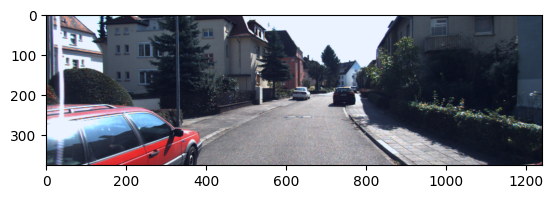

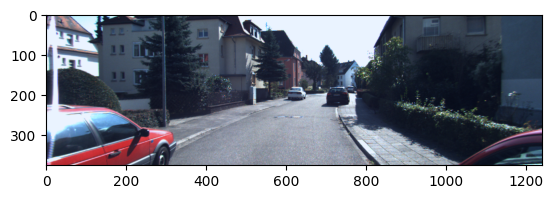

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [5]:
left_img, right_img, vox_labels = train_set.get_data(666)
plt.figure(1)
plot_tensor2d(left_img)
plt.figure(2)
plot_tensor2d(right_img)
plt.show()
from dataset.utils import visualize_voxels
visualize_labeled_array3d(vox_labels.numpy().astype(np.uint16), size = 0.5, marker = 'box')

In [6]:
left_img.shape

torch.Size([3, 376, 1241])

In [7]:
train_dataloader = DataLoader(train_set, batch_size=6, shuffle=True)

In [8]:
num_classes = len(train_set.class_names)
class_weights = train_set.class_weights

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [16]:
import sys
repo_path = '/workspace/stereo-transformer'
pretrained_weight_path = '/workspace/PretrainedWeights/kitti_finetuned_model.pth.tar'
sys.path.insert(0, repo_path) 
from module.sttr import STTR
from utilities.misc import NestedTensor, batched_index_select

sys.path.insert(0, repo_path + '/dataset') 
import stereo_albumentation
from preprocess import normalization, compute_left_occ_region

def load_STTR_model(repo_path, pretrained_weight_path):
    # Default parameters
    args = type('', (), {})() # create empty args
    args.channel_dim = 128
    args.position_encoding='sine1d_rel'
    args.num_attn_layers=6
    args.nheads=8
    args.regression_head='ot'
    args.context_adjustment_layer='cal'
    args.cal_num_blocks=8
    args.cal_feat_dim=16
    args.cal_expansion_ratio=4


    model = STTR(args).cuda().eval()

    # Load the pretrained model
    model_file_name = pretrained_weight_path
    checkpoint = torch.load(model_file_name)
    pretrained_dict = checkpoint['state_dict']
    model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
    print("Pre-trained model successfully loaded.")
    
    return model

class STTR_InputAdapterLayer(nn.Module):
    def __init__(self, downsample=3):
        super(STTR_InputAdapterLayer, self).__init__()
        self.downsample = downsample

    def forward(self, input_tensor):
        input_tensor = input_tensor.permute(0, 1, 4, 2, 3)
        bs, _, _, h, w = input_tensor.shape  # Extract batch size, height, and width

        # Extract left and right images from the input tensor
        left_imgs = input_tensor[:, 0, :, :, :]
        right_imgs = input_tensor[:, 1, :, :, :]

        col_offset = int(self.downsample / 2)
        row_offset = int(self.downsample / 2)
        sampled_cols = torch.arange(col_offset, w, self.downsample)[None,].expand(bs, -1).cuda()
        sampled_rows = torch.arange(row_offset, h, self.downsample)[None,].expand(bs, -1).cuda()

        
        normalized_left = normalization(left_imgs)  
        normalized_right = normalization(right_imgs)  

        # Create NestedTensor for the batch
        nested_tensor = NestedTensor(normalized_left, normalized_right, 
                                     sampled_cols=sampled_cols, sampled_rows=sampled_rows)

        return nested_tensor


stereo_transformer = load_STTR_model(repo_path, pretrained_weight_path)
print("Number of parameters (in millions):", sum(p.numel() for p in stereo_transformer.parameters() if p.requires_grad) / 1_000_000, 'M')


ModuleNotFoundError: No module named 'dataset.stereo_albumentation'

In [36]:
#stereo_transformer.backbone

In [45]:
class STTR_Feat(nn.Module):
    def __init__(self, STTR_pretrained):
        super(STTR_Feat, self).__init__()
        self.sttr_adapter_layer = STTR_InputAdapterLayer(downsample=3)
        self.stereo_transformer = STTR_pretrained
        
    
    # input_tensor 'x' should be batched stereo image tensor with
    # shape: N x 2 x C x H x W, where N is the batch size, 
    # 2 for left and right images, 
    # and C,H,W are the dimensions of RGB images 
    def forward(self, x): 
        x = self.sttr_adapter_layer(x)
        bs, _, h, w = x.left.size()
        feat = self.stereo_transformer.backbone(x)
        tokens = self.stereo_transformer.tokenizer(feat)
        pos_enc = self.stereo_transformer.pos_encoder(x)
        # separate left and right
        feat_left = tokens[:bs]
        feat_right = tokens[bs:]  # NxCxHxW
        # downsample
        if x.sampled_cols is not None:
            feat_left = batched_index_select(feat_left, 3, x.sampled_cols)
            feat_right = batched_index_select(feat_right, 3, x.sampled_cols)
        if x.sampled_rows is not None:
            feat_left = batched_index_select(feat_left, 2, x.sampled_rows)
            feat_right = batched_index_select(feat_right, 2, x.sampled_rows)
        attn_weight = model.transformer(feat_left, feat_right, pos_enc)
        
        
        return attn_weight

In [46]:
import torch
import torch.nn as nn

class StereoToVoxelNet(nn.Module):
    def __init__(self, input_channels=3):
        super(StereoToVoxelNet, self).__init__()

        # Convolutional layers for stereo images
        self.conv1_stereo = nn.Conv2d(input_channels * 2, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_stereo = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3_stereo = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Convolutional layers for attention features
        self.conv1_attn = nn.Conv2d(125, 64, kernel_size=3, stride=2, padding=1)
        self.conv2_attn = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # Adaptive pooling to ensure the spatial dimensions are compatible
        self.adaptive_pool_stereo = nn.AdaptiveAvgPool2d((128, 128))
        self.adaptive_pool_attn = nn.AdaptiveAvgPool2d((128, 128))

        # Final layers
        self.final_conv = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)  # Combining both streams
        self.reshape = nn.Unflatten(1, (128, 128, 128, 16))

    def forward(self, stereo_imgs, attn_feat):
        # Process stereo images
        x_stereo = stereo_imgs.view(-1, stereo_imgs.size(2), stereo_imgs.size(3), stereo_imgs.size(4))
        x_stereo = nn.ReLU()(self.conv1_stereo(x_stereo))
        x_stereo = nn.ReLU()(self.conv2_stereo(x_stereo))
        x_stereo = nn.ReLU()(self.conv3_stereo(x_stereo))
        x_stereo = self.adaptive_pool_stereo(x_stereo)

        # Process attention features
        x_attn = nn.ReLU()(self.conv1_attn(attn_feat))
        x_attn = nn.ReLU()(self.conv2_attn(x_attn))
        x_attn = self.adaptive_pool_attn(x_attn)

        # Combine both streams
        x_combined = torch.cat([x_stereo, x_attn], dim=1)

        # Final processing
        x = nn.ReLU()(self.final_conv(x_combined))
        x = x.view(stereo_imgs.size(0), -1, 128, 128, 16)  # Reshape to [N, 128, 128, 128, 16]

        return x

# Example usage
# model = StereoToVoxelNet(input_channels=3)
# stereo_tensor = torch.randn(1, 2, 3, 224, 224)  # Example stereo input
# attn_tensor = torch.randn(1, 125, 414, 414)    # Example attention feature tensor
# output = model(stereo_tensor, attn_tensor)
# print(output.shape)  # Should be torch.Size([1, 128, 128, 128, 16])


In [47]:
from utils import sem_scal_loss, geo_scal_loss, CE_ssc_loss
from utils import Header


In [48]:

class STFB_Occ(nn.Module):
    def __init__(self, num_classes, STTR_pretrained):
        super(STFB_Occ, self).__init__()
        self.sttr_feat = STTR_Feat(STTR_pretrained)
        self.stvox = StereoToVoxelNet()
        self.occ_head = Header(class_num=num_classes, feature=128)
        
    
    # input_tensor 'x' should be batched stereo image tensor with
    # shape: N x 2 x C x H x W, where N is the batch size, 
    # 2 for left and right images, 
    # and C,H,W are the dimensions of RGB images 
    def forward(self, x): 
        sttr_attn = self.sttr_feat(x)
        x = self.stvox(x)
        out = self.occ_head(x)
        return out
    

In [49]:
model = STFB_Occ(num_classes=num_classes, STTR_pretrained=stereo_transformer)
print("Number of parameters (in millions):", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000, 'M')


Number of parameters (in millions): 3.051719 M


In [50]:
from tqdm import tqdm
from torch.optim import Adam
import torch.nn.functional as F
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
num_epochs = 3
best_loss = np.inf
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (image2, image3, voxel_labels) in tqdm(enumerate(train_dataloader),total = len(train_dataloader)):
        inputs = torch.stack((image2, image3), dim=1).to(device)
        voxel_labels.to(device)
        
        voxel_pred_1h = model(inputs)
        
        loss = sem_scal_loss(voxel_pred_1h, voxel_labels)
        loss += geo_scal_loss(voxel_pred_1h, voxel_labels)
        loss += CE_ssc_loss(voxel_pred_1h, voxel_labels, class_weights)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    with torch.no_grad():
        for (image2, image3, voxel_labels) in tqdm(val_dataloader):
            inputs = torch.stack((image2, image3), dim=1).to(device)
            voxel_labels = voxel_labels.to(device)
            
            voxel_pred_1h = model(inputs)
            loss = sem_scal_loss(voxel_pred_1h, voxel_labels)
            loss += geo_scal_loss(voxel_pred_1h, voxel_labels)
            loss += CE_ssc_loss(voxel_pred_1h, voxel_labels, class_weights)
            
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'STFBOcc.pth')
        best_loss = (train_loss / len(train_dataloader))

  0%|          | 0/606 [00:01<?, ?it/s]


NameError: name 'normalization' is not defined